In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as anneu


In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'subject_project = "collab_citricacid"' & 'lab_name="mainenlab"'

########### WEIGHINGS ########### 

weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-10-24"'
baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-09-24"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
bb = subj * avg_baseline_weight_date

weight_df = pd.DataFrame(b.fetch(as_dict=True))
#weight_df.tail(n=10)

baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
baseline_df.tail(n=10)

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,lab_name,subjectlab_ts,subjectproject_ts,avg_weight
187,c600bc40-2f6f-449f-99be-562f6fbe331e,collab_citricacid,2018-09-17,ZM_210,F,2018-07-23,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:38,mainenlab,2020-02-04 12:54:01,2020-02-04 12:53:50,19.420000
188,c600bc40-2f6f-449f-99be-562f6fbe331e,collab_citricacid,2018-09-18,ZM_210,F,2018-07-23,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:38,mainenlab,2020-02-04 12:54:01,2020-02-04 12:53:50,19.219999
189,c600bc40-2f6f-449f-99be-562f6fbe331e,collab_citricacid,2018-09-19,ZM_210,F,2018-07-23,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:38,mainenlab,2020-02-04 12:54:01,2020-02-04 12:53:50,19.860001
190,c600bc40-2f6f-449f-99be-562f6fbe331e,collab_citricacid,2018-09-20,ZM_210,F,2018-07-23,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:38,mainenlab,2020-02-04 12:54:01,2020-02-04 12:53:50,19.950001
191,c600bc40-2f6f-449f-99be-562f6fbe331e,collab_citricacid,2018-09-21,ZM_210,F,2018-07-23,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:38,mainenlab,2020-02-04 12:54:01,2020-02-04 12:53:50,20.090000
192,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-09-18,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2020-02-04 12:54:03,2020-02-04 12:53:52,19.740000
193,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-09-19,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2020-02-04 12:54:03,2020-02-04 12:53:52,19.830000
194,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-09-20,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2020-02-04 12:54:03,2020-02-04 12:53:52,19.969999
195,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-09-21,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2020-02-04 12:54:03,2020-02-04 12:53:52,20.879999
196,f8f2ec95-bc15-4c72-bf93-74185cbd049f,collab_citricacid,2018-09-17,ZM_338,M,2018-08-08,None,None,CCU - Margarida colonies,1,None,2019-09-25 01:33:41,mainenlab,2020-02-04 12:54:03,2020-02-04 12:53:52,19.680000


In [3]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

normalized_df = weight_df.copy()
# day 0 is the start of the experiment
normalized_df['session_day'] = (normalized_df['session_date'] - (datetime(2018, 9, 24)).date()).dt.days

normalized2 = pd.DataFrame([])
for index, sjdat in normalized_df.groupby(['subject_uuid']):
    sjdat['avg_weight'] = sjdat['avg_weight'] / sjdat.loc[sjdat.session_day < 1, 'avg_weight'].mean()
    normalized2 = normalized2.append(sjdat)

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

# now, we want to map these onto the subject names
CTL = 'Free water'
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'

condition_map = {'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL, 
'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD}

normalized2['condition'] = normalized2.subject_nickname.map(condition_map)


/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


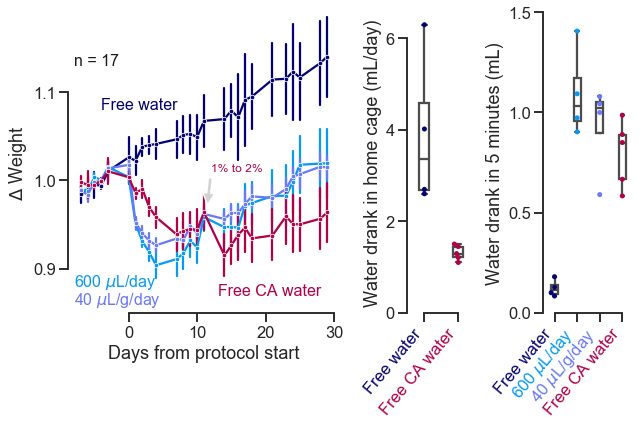

In [4]:
########### PLOTS ########### 
palette = sns.xkcd_palette(['deep blue', 'azure', 'cornflower', 'raspberry'])
hue_order = ['Free water', 'Fixed amount', 'Weight-based amount', 'Citric Acid']

f, ax = plt.subplots(ncols=3, nrows=1, gridspec_kw=dict(width_ratios=[3, 0.75, 1]), figsize=(9, 6))
    
sns.lineplot(x="session_day", y="avg_weight", err_style='bars', marker='.',
             ci=68, hue="condition", data=normalized2, ax=ax[0], legend=False, 
            palette=palette, hue_order=hue_order)
ax[0].set_xlabel("Days from protocol start")    
ax[0].set_ylabel("$\Delta$ Weight")         
ax[0].set(ylim=[0.85, 1.19], yticks=[0.9, 1, 1.1])
ax[0].text(-4, 1.08,'Free water', {'color':palette[0], 'fontsize':16})
ax[0].text(-8, 0.88,'600 $\mu$L/day', {'color':palette[1], 'fontsize':16})
ax[0].text(-8, 0.86,'40 $\mu$L/g/day', {'color':palette[2], 'fontsize':16})
ax[0].text(13, 0.87,'Free CA water', {'color':palette[3], 'fontsize':16})
ax[0].annotate('1% to 2%', xy=(11.5, 0.97), xytext=(12, 1.01), color=palette[3], fontsize=12,
              arrowprops=dict(facecolor='lightgrey', shrink=0.05))
ax[0].text(-8, 1.13, 'n = 17', {'color':'k', 'fontsize':16})

########### WATER ADMINISTRATIONS ########### 
water_with_date = (action.WaterAdministration & subj).proj('watertype_name', 'water_administered', 'adlib', # it can restrict on the subj here but it will anyway do later
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date) & 'session_date < "2018-10-24"'& 'session_date > "2018-10-05"'
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
b = subj * total_water_date # including water will exclude mice with ad lib water
df = pd.DataFrame(b.fetch(as_dict=True))

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

df['condition'] = df.subject_nickname.map(condition_map)

########### b ########### 
sns.swarmplot(x="condition", y="total_water", order=['Free water', 'Citric Acid'],  
              data=df.groupby(['subject_uuid', 'condition'])['total_water'].mean().reset_index(),
              palette = sns.xkcd_palette(['deep blue', 'raspberry']), ax=ax[1])
sns.boxplot(x="condition", y="total_water", order=[ 'Free water', 'Citric Acid'], 
            data=df.groupby(['subject_uuid', 'condition'])['total_water'].mean().reset_index(), 
            fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax[1])
ax[1].set(ylabel='Water drank in home cage (mL/day)', xlabel='')
ax[1].set_xticklabels(['Free water', 'Free CA water'])
ax[1].set_yticks([0, 2, 4, 6])

########### WATER ########### 
water= pd.read_csv('data/thirst.csv') # first date is exclude (habituation)
# remove measurements from 4-10-2018, CA mice still on 1%
water = water[~water['date'].str.match('4-10-2018')]

# MAP MICE ONTO DIFFERENT CONDITIONS
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

water['condition'] = water.subject.map(condition_map)

########### c ########### 
sns.swarmplot(x="condition", y="water_amount", order=hue_order,  
              data=water.groupby(['condition', 'subject'])['water_amount'].mean().reset_index(),
              ax=ax[2], palette=palette)
sns.boxplot(x="condition", y="water_amount", order=hue_order, 
            data=water.groupby(['condition', 'subject'])['water_amount'].mean().reset_index(),
            fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax[2])
ax[2].set(ylabel='Water drank in 5 minutes (mL)', xlabel='')
ax[2].set_xticklabels(['Free water', '600 $\mu$L/day', '40 $\mu$L/g/day', 'Free CA water'])
ax[2].set_yticks([0, 0.5, 1, 1.5])

# layout with rotated ticks
for ticklabel, tickcolor in zip(ax[1].get_xticklabels(), [palette[0], palette[3]]):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(50)
    ticklabel.set(ha='right')
    
for ticklabel, tickcolor in zip(ax[2].get_xticklabels(), palette):
    ticklabel.set_color(tickcolor)
    ticklabel.set_rotation(50)
    ticklabel.set(ha='right')
    
f.tight_layout()
sns.despine(trim=True)
f.savefig(os.path.join(figpath, "citricacid_study1.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1.png"), dpi=600)

In [5]:
water.groupby(['condition', 'subject'])['water_amount'].mean().reset_index().groupby(['condition']).describe()

water_amount                                          \
                           count      mean       std       min       25%   
condition                                                                  
Citric Acid                  5.0  0.795333  0.165875  0.583333  0.666667   
Fixed amount                 4.0  1.094167  0.222617  0.903333  0.955833   
Free water                   4.0  0.122500  0.042284  0.083333  0.095833   
Weight-based amount          4.0  0.928333  0.227913  0.590000  0.897500   

                                                   
                          50%       75%       max  
condition                                          
Citric Acid          0.850000  0.890000  0.986667  
Fixed amount         1.033333  1.171667  1.406667  
Free water           0.113333  0.140000  0.180000  
Weight-based amount  1.021667  1.052500  1.080000